https://www.kaggle.com/asindico/a-japanese-journey
https://www.kaggle.com/timolee/feeling-hungry-a-beginner-s-guide-to-arima-models

In [23]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
%%html
    <style>.container { width:90% !important;} </style>

In [22]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import glob, re
import numpy as np
import pandas as pd
from sklearn import *
from datetime import datetime
#Adapted from: the1owl - Surprise Me - https://www.kaggle.com/the1owl/surprise-me/code
train = pd.read_csv('../input/air_visit_data.csv')
airstore = pd.read_csv('../input/air_store_info.csv')
hstore = pd.read_csv('../input/hpg_store_info.csv')
air = pd.read_csv('../input/air_reserve.csv')
hpg = pd.read_csv('../input/hpg_reserve.csv')
idres = pd.read_csv('../input/store_id_relation.csv')
test = pd.read_csv('../input/sample_submission.csv')
hol = pd.read_csv('../input/date_info.csv').rename(columns={'calendar_date':'visit_date'})


hpg = pd.merge(hpg, idres, how='inner', on=['hpg_store_id'])

for df in [air,hpg]:
    df['visit_datetime'] = pd.to_datetime(df['visit_datetime'])
    df['visit_datetime'] = df['visit_datetime'].dt.date
    df['reserve_datetime'] = pd.to_datetime(df['reserve_datetime'])
    df['reserve_datetime'] = df['reserve_datetime'].dt.date
    df['reserve_datetime_diff'] = df.apply(lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)
    tmp1 = df.groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].sum().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs1', 'reserve_visitors':'rv1'})
    tmp2 = df.groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].mean().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs2', 'reserve_visitors':'rv2'})
    df = pd.merge(tmp1, tmp2, how='inner', on=['air_store_id','visit_date'])

train['visit_date'] = pd.to_datetime(train['visit_date'])
train['dow'] = train['visit_date'].dt.dayofweek
train['year'] = train['visit_date'].dt.year
train['month'] = train['visit_date'].dt.month
train['visit_date'] = train['visit_date'].dt.date

test['visit_date'] = test['id'].map(lambda x: str(x).split('_')[2])
test['air_store_id'] = test['id'].map(lambda x: '_'.join(x.split('_')[:2]))
test['visit_date'] = pd.to_datetime(test['visit_date'])
test['dow'] = test['visit_date'].dt.dayofweek
test['year'] = test['visit_date'].dt.year
test['month'] = test['visit_date'].dt.month
test['visit_date'] = test['visit_date'].dt.date

unique_stores = test['air_store_id'].unique()
stores = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores)}) for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)

#sure it can be compressed...
tmp = train.groupby(['air_store_id','dow'], as_index=False)['visitors'].min().rename(columns={'visitors':'min_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 
tmp = train.groupby(['air_store_id','dow'], as_index=False)['visitors'].mean().rename(columns={'visitors':'mean_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = train.groupby(['air_store_id','dow'], as_index=False)['visitors'].median().rename(columns={'visitors':'median_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = train.groupby(['air_store_id','dow'], as_index=False)['visitors'].max().rename(columns={'visitors':'max_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = train.groupby(['air_store_id','dow'], as_index=False)['visitors'].count().rename(columns={'visitors':'count_observations'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 

stores = pd.merge(stores, airstore, how='left', on=['air_store_id']) 
lbl = preprocessing.LabelEncoder()
stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])

hol['visit_date'] = pd.to_datetime(hol['visit_date'])
hol['day_of_week'] = lbl.fit_transform(hol['day_of_week'])
hol['visit_date'] = hol['visit_date'].dt.date
train = pd.merge(train, hol, how='left', on=['visit_date']) 
test = pd.merge(test, hol, how='left', on=['visit_date'])

train = pd.merge(train, stores, how='left', on=['air_store_id','dow']) 
test = pd.merge(test, stores, how='left', on=['air_store_id','dow'])

for df in [air,hpg]:
    df.rename(columns={'visit_datetime':'visit_date'},inplace=True)
    train = pd.merge(train, df, how='left', on=['air_store_id','visit_date']) 
    test = pd.merge(test, df, how='left', on=['air_store_id','visit_date'])

train['id'] = train.apply(lambda r: '_'.join([str(r['air_store_id']), str(r['visit_date'])]), axis=1)

#train['total_reserv_sum'] = train['rv1_x'] + train['rv1_y']
#train['total_reserv_mean'] = (train['rv2_x'] + train['rv2_y']) / 2
#train['total_reserv_dt_diff_mean'] = (train['rs2_x'] + train['rs2_y']) / 2

#test['total_reserv_sum'] = test['rv1_x'] + test['rv1_y']
#test['total_reserv_mean'] = (test['rv2_x'] + test['rv2_y']) / 2
#test['total_reserv_dt_diff_mean'] = (test['rs2_x'] + test['rs2_y']) / 2

# NEW FEATURES FROM JMBULL

In [24]:
train.head()
train.shape
train.columns

,air_store_id,visit_date,visitors,dow,year,month,day_of_week,holiday_flg,min_visitors,mean_visitors,...,latitude,longitude,reserve_datetime_x,reserve_visitors_x,reserve_datetime_diff_x,hpg_store_id,reserve_datetime_y,reserve_visitors_y,reserve_datetime_diff_y,id
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1,6,0,7.0,23.843750,...,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24_2016-01-13
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1,4,0,2.0,20.292308,...,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24_2016-01-14
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1,0,0,4.0,34.738462,...,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24_2016-01-15
3,air_ba937bf13d40fb24,2016-01-16,22,5,2016,1,2,0,6.0,27.651515,...,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24_2016-01-16
4,air_ba937bf13d40fb24,2016-01-18,6,0,2016,1,1,0,2.0,13.754386,...,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24_2016-01-18


(338950, 25)

Index([u'air_store_id', u'visit_date', u'visitors', u'dow', u'year', u'month',
       u'day_of_week', u'holiday_flg', u'min_visitors', u'mean_visitors',
       u'median_visitors', u'max_visitors', u'count_observations',
       u'air_genre_name', u'air_area_name', u'latitude', u'longitude',
       u'reserve_datetime_x', u'reserve_visitors_x',
       u'reserve_datetime_diff_x', u'hpg_store_id', u'reserve_datetime_y',
       u'reserve_visitors_y', u'reserve_datetime_diff_y', u'id'],
      dtype='object')

In [49]:
tmp = train.groupby(['air_store_id','dow'], as_index=False)['visitors'].min()
tmp.head()

air_store_id          dow
air_00a91d42b08b08d9  0       1
                      1       1
                      2      15
                      3      15
                      4      17
Name: visitors, dtype: int64

In [5]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import glob, re
import numpy as np
import pandas as pd
from sklearn import *
from datetime import datetime
train = pd.read_csv('../input/air_visit_data.csv')
airstore = pd.read_csv('../input/air_store_info.csv')
hstore = pd.read_csv('../input/hpg_store_info.csv')
train = pd.merge(train, airstore, how='left', on=['air_store_id']) 
train.head()

,air_store_id,visit_date,visitors,air_genre_name,air_area_name,latitude,longitude
0,air_ba937bf13d40fb24,2016-01-13,25,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
1,air_ba937bf13d40fb24,2016-01-14,32,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
2,air_ba937bf13d40fb24,2016-01-15,29,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
3,air_ba937bf13d40fb24,2016-01-16,22,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
4,air_ba937bf13d40fb24,2016-01-18,6,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [13]:
lbl = preprocessing.LabelEncoder()
train['air_genre_name'] = lbl.fit_transform(train['air_genre_name'])
train['air_area_name'] = lbl.fit_transform(train['air_area_name'])
train.head()

g=train.groupby(['air_genre_name','visit_date'])
df=g['visitors'].sum().reset_index().rename(columns={'visitors':'visitors_total'})

#tmp=g['air_area_name'].mean().reset_index().rename(columns={'visitors':'visitors_count'})
#df=pd.merge(df, tmp, how='left', on=['air_genre_name','visit_date'])
df.head()
genres=df.air_genre_name.unique()
for g in genres:
    print g,df[df.air_genre_name==g].shape

,air_store_id,visit_date,visitors,air_genre_name,air_area_name,latitude,longitude
0,air_ba937bf13d40fb24,2016-01-13,25,4,62,35.658068,139.751599
1,air_ba937bf13d40fb24,2016-01-14,32,4,62,35.658068,139.751599
2,air_ba937bf13d40fb24,2016-01-15,29,4,62,35.658068,139.751599
3,air_ba937bf13d40fb24,2016-01-16,22,4,62,35.658068,139.751599
4,air_ba937bf13d40fb24,2016-01-18,6,4,62,35.658068,139.751599


,air_genre_name,visit_date,visitors_total
0,0,2016-05-01,65
1,0,2016-05-07,49
2,0,2016-05-08,51
3,0,2016-05-09,21
4,0,2016-05-10,36


0 (338, 3)
1 (478, 3)
2 (478, 3)
3 (477, 3)
4 (478, 3)
5 (291, 3)
6 (478, 3)
7 (478, 3)
8 (478, 3)
9 (292, 3)
10 (477, 3)
11 (478, 3)
12 (478, 3)
13 (477, 3)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


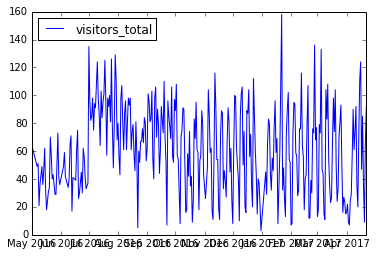

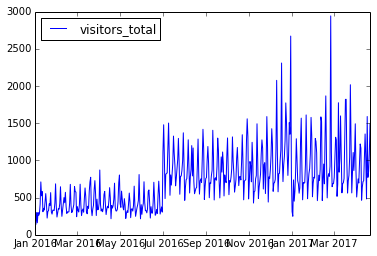

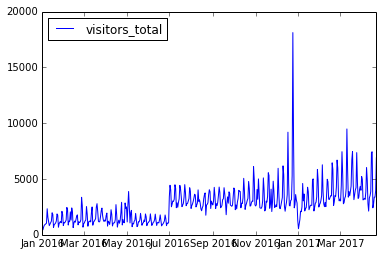

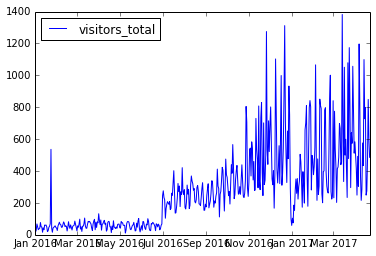

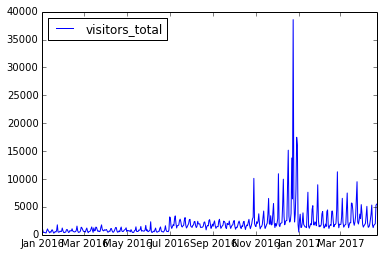

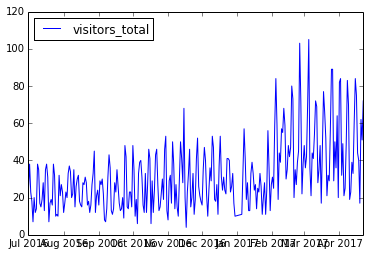

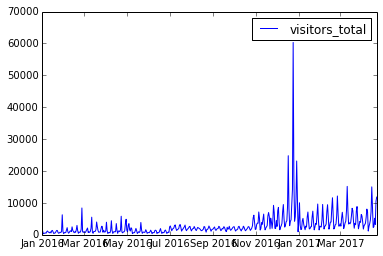

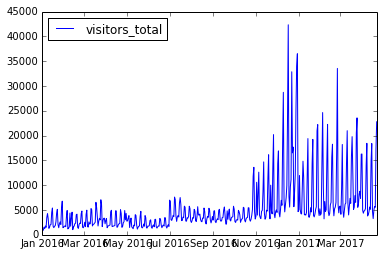

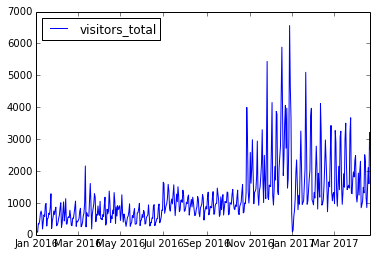

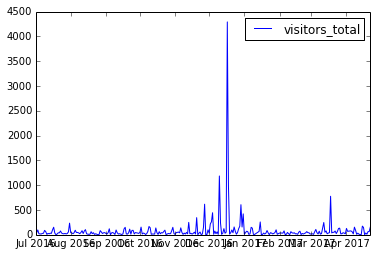

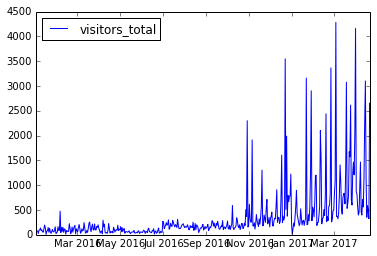

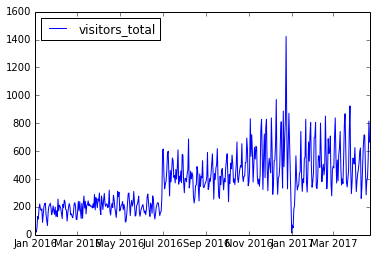

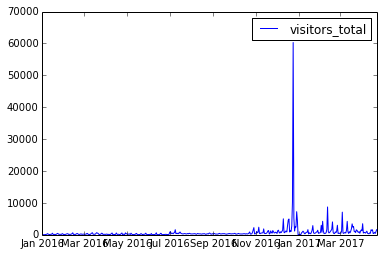

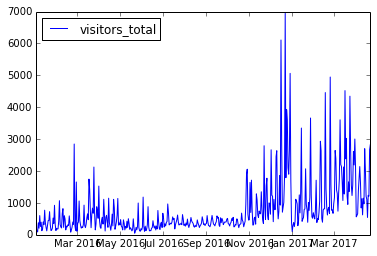

In [143]:
for g in genres:
    gen=df[df.air_genre_name==g]
    gen.drop('air_genre_name',axis=1,inplace=True)
    gen.set_index('visit_date', inplace=True)
    gen.index.name=None
    gen.plot();
    #gen.head()

In [8]:
print "air, hpg"
air.head(3)
hpg.head(3)
print "test,train="
test.head(3)
train.head(3)
train.iloc[0]

air, hpg


,air_store_id,visit_date,reserve_datetime,reserve_visitors,reserve_datetime_diff
0,air_877f79706adbfb06,2016-01-01,2016-01-01,1,0
1,air_db4b38ebe7a7ceff,2016-01-01,2016-01-01,3,0
2,air_db4b38ebe7a7ceff,2016-01-01,2016-01-01,6,0


,hpg_store_id,visit_date,reserve_datetime,reserve_visitors,air_store_id,reserve_datetime_diff
0,hpg_878cc70b1abc76f7,2016-01-01,2016-01-01,4,air_db80363d35f10926,0
1,hpg_878cc70b1abc76f7,2016-01-02,2016-01-02,2,air_db80363d35f10926,0
2,hpg_878cc70b1abc76f7,2016-01-03,2016-01-02,6,air_db80363d35f10926,1


test,train=


,id,visitors,visit_date,air_store_id,dow,year,month,day_of_week,holiday_flg,min_visitors,...,air_area_name,latitude,longitude,reserve_datetime_x,reserve_visitors_x,reserve_datetime_diff_x,hpg_store_id,reserve_datetime_y,reserve_visitors_y,reserve_datetime_diff_y
0,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23,air_00a91d42b08b08d9,6,2017,4,3,0,2.0,...,44,35.694003,139.753595,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24,air_00a91d42b08b08d9,0,2017,4,1,0,1.0,...,44,35.694003,139.753595,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25,air_00a91d42b08b08d9,1,2017,4,5,0,1.0,...,44,35.694003,139.753595,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,air_store_id,visit_date,visitors,dow,year,month,day_of_week,holiday_flg,min_visitors,mean_visitors,...,latitude,longitude,reserve_datetime_x,reserve_visitors_x,reserve_datetime_diff_x,hpg_store_id,reserve_datetime_y,reserve_visitors_y,reserve_datetime_diff_y,id
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1,6,0,7.0,23.843750,...,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24_2016-01-13
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1,4,0,2.0,20.292308,...,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24_2016-01-14
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1,0,0,4.0,34.738462,...,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24_2016-01-15


air_store_id                          air_ba937bf13d40fb24
visit_date                                      2016-01-13
visitors                                                25
dow                                                      2
year                                                  2016
month                                                    1
day_of_week                                              6
holiday_flg                                              0
min_visitors                                             7
mean_visitors                                      23.8438
median_visitors                                         25
max_visitors                                            57
count_observations                                      64
air_genre_name                                           4
air_area_name                                           62
latitude                                           35.6581
longitude                                          139.7

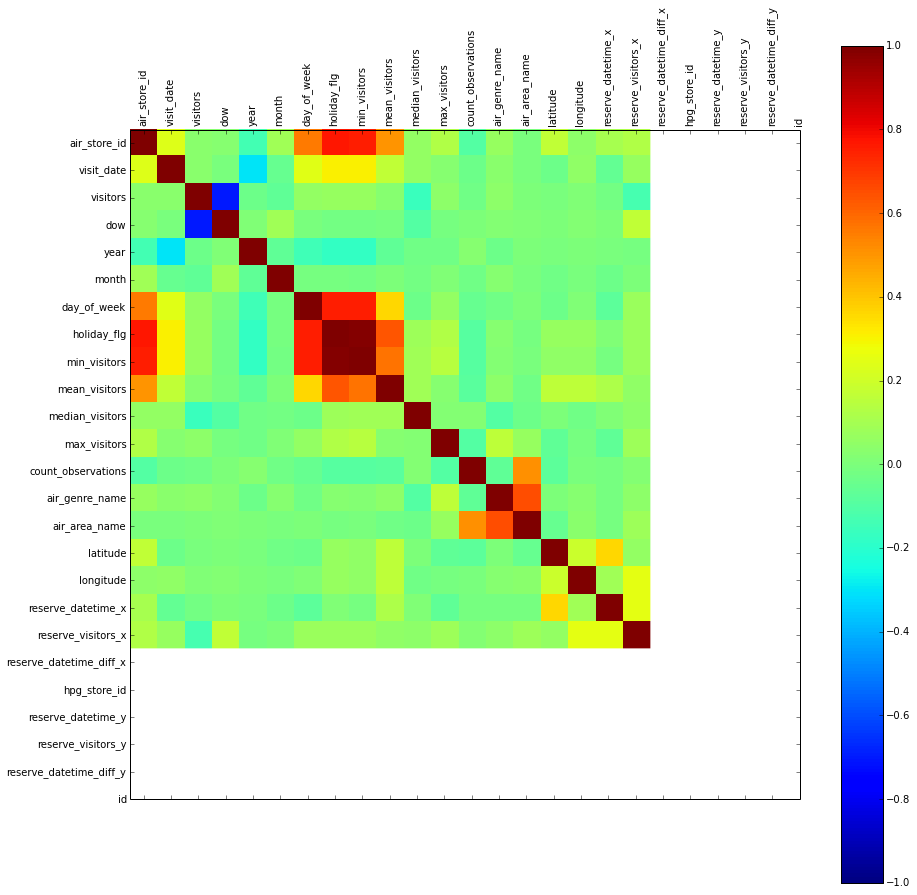

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
cax = ax.matshow(train.corr(), vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,train.shape[1],1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(train.columns,rotation=90)
ax.set_yticklabels(train.columns)
plt.show();